In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.oriented_clusters.grammar_with_extra_pathway import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
Meshcat url:  http://127.0.0.1:7005/static/


In [3]:
# Draw a random sample from the grammar and visualize it.
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = OrientedClusterRoot,
    root_node_tf = torch.eye(4)
)
tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()
print("Sampled scene with %d clusters and %d boxes." % 
      (len(tree.find_nodes_by_type(OrientedCluster)),
       len(tree.find_nodes_by_type(LongBox))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.01)

[2021-10-14 01:00:37.442] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Sampled scene with 3 clusters and 6 boxes.
Sampled tree has score -5.437420


Super tree has 24 nodes


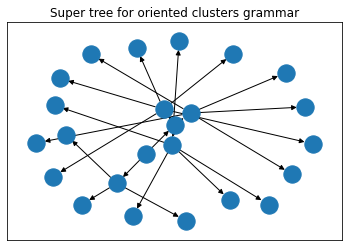

In [4]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [5]:
# Parse this tree
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True, max_scene_extent_in_any_dir=5., N_solutions=10
)
mip_optimized_trees = get_optimized_trees_from_mip_results(inference_results)
vis["mip"].delete()
for k, mip_optimized_tree in enumerate(mip_optimized_trees):
    draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip/tree_%d" % k, node_sphere_size=0.01)

for node in mip_optimized_tree:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

Starting setup.
Activation vars allocated.
Continuous variables and SO(3) constraints allocated for all equivalence sets.
Setup time:  0.562309741973877
Num vars:  4092
Num constraints:  12324
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Oct 14 01:00:38 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 9348 rows, 4092 columns and 62233 nonzeros
Model fingerprint: 0xe6034a99
Model has 63 quadratic objective terms
Variable types: 3849 continuous, 243 integer (243 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [1e-18, 1e+03]
  QObjective range [1e+00, 1e+03]
  Bounds range     [1e+00, 5e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 3363 rows and 231 columns
Presolve time: 0.12s
Presolved: 5985 rows, 3861 columns, 46143 nonzeros
Presolved model has 63 quadratic objective terms
Variable types: 3666 continuous, 195 integer (195 binary)

Root relaxation: objective -8.027440

In [6]:
print("Optimized tree scores: ", [mip_optimized_tree.score(include_discrete=True, include_continuous=True) for mip_optimized_tree in mip_optimized_trees])
print("GT tree score: ", tree.score(include_discrete=True, include_continuous=True))

Optimized tree scores:  [tensor([-2.6973]), tensor([-2.6976]), tensor([-2.6974]), tensor([-2.6973]), tensor([-2.6973]), tensor([-2.6974]), tensor([-2.6973]), tensor([-2.6974]), tensor([-2.6980]), tensor([-2.6975])]
GT tree score:  tensor([-5.4374])


In [7]:
# Do NLP refinement of tree
refinement_results = optimize_scene_tree_with_nlp(grammar, mip_optimized_trees[0], verbose=True)
refined_tree = refinement_results.refined_tree
draw_scene_tree_structure_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="refined_scene_tree", node_sphere_size=0.01)

<spatial_scene_grammars.rules.SamePositionRule object at 0x7fd37072fe10> <spatial_scene_grammars.rules.SameRotationRule object at 0x7fd37072ff98>
<spatial_scene_grammars.rules.SamePositionRule object at 0x7fd3706c00b8> <spatial_scene_grammars.rules.SameRotationRule object at 0x7fd3706c0128>
<spatial_scene_grammars.rules.WorldFrameGaussianOffsetRule object at 0x7fd3706c0748> <spatial_scene_grammars.rules.WorldFrameBinghamRotationRule object at 0x7fd3706c0898>
<spatial_scene_grammars.rules.WorldFrameGaussianOffsetRule object at 0x7fd3706c0f98> <spatial_scene_grammars.rules.WorldFrameBinghamRotationRule object at 0x7fd37072d128>
<spatial_scene_grammars.rules.WorldFrameGaussianOffsetRule object at 0x7fd37072de48> <spatial_scene_grammars.rules.WorldFrameBinghamRotationRule object at 0x7fd37072df98>
<spatial_scene_grammars.rules.WorldFrameGaussianOffsetRule object at 0x7fd3706db2b0> <spatial_scene_grammars.rules.WorldFrameBinghamRotationRule object at 0x7fd3706db400>
<spatial_scene_grammars.

In [8]:
print("Pre-refined tree score: ", mip_optimized_trees[0].score(include_discrete=False))
print("Refined tree score: ", refined_tree.score(include_discrete=False))
print("Original tree score: ", tree.score(include_discrete=False))

Pre-refined tree score:  tensor([3.8034])
Refined tree score:  tensor([3.6659])
Original tree score:  tensor([1.0633])
